In [1]:
import torch
import torch.nn as nn
import numpy as np

from model import RecEnvSimModel
from data_loader import PongDataLoader3D

In [2]:
train_data_loader = PongDataLoader3D('dataset40_3d.zip')
test_data_loader = PongDataLoader3D('dataset10_3d.zip')

# get shapes
dim1 , dim2, depth = train_data_loader.first_dim , train_data_loader.second_dim , train_data_loader.depth
print('image shape is ',(dim1,dim2,depth))

image shape is  (210, 160, 3)


In [3]:
LSTM_config = (32*11*8,
               1024,
               3,
               2048)

encoder_config = (3, # in_channels
                  [64,32,32,32], # num_filters_list 
                  [(8,8),(6,6),(6,6),(4,4)], # filter_size_list
                  [2 for _ in range(4)], # stride_list
                  [(0,1),(1,1),(1,1),(0,0)]) # padding_list

decoder_config = (LSTM_config[1]+LSTM_config[1], # input_length
                  [32,11,8], # deconv_input_shape
                  [32,32,64,3], # num_filters_list 
                  [(4,4),(6,6),(6,6),(8,8)], # filter_size_list
                  [2 for _ in range(4)], # stride_list
                  [(0,0),(1,1),(1,1),(0,1)]) # padding_list


In [4]:
model = RecEnvSimModel(LSTM_config, encoder_config, decoder_config)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [5]:
temp_states, temp_actions = train_data_loader.get_data(1,15)
states_tensor = torch.Tensor(temp_states) # of shape (1,16,depth,dim1,dim2)
actions_tensor = nn.functional.one_hot(torch.Tensor(temp_actions.astype(int)).long(),num_classes=3) # if I don't put the long() method, one_hot won't work
# actions_tensor = torch.transpose(actions_tensor,-1,-2).float() # swap dimensions -1 and -2
actions_tensor = actions_tensor[:,:,:,None].float()

# actions_tensor is of shape (1,16,3)
init_hidden = torch.zeros([1,LSTM_config[1]])
init_cell = torch.zeros([1,LSTM_config[1]])
out, hc = model(states_tensor[0:1,0,:,:,:], actions_tensor[0:1,0,:,:], (init_hidden,init_cell))

c:\Users\rsafa\Desktop\Ramin\venv\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
c:\Users\rsafa\Desktop\Ramin\venv\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [6]:
print(hc[0].shape)
print(hc[1].shape)
print(states_tensor[0:1,0,:,:].shape)
print(out.shape)

torch.Size([1, 1024])
torch.Size([1, 1024])
torch.Size([1, 3, 210, 160])
torch.Size([1, 3, 210, 160])


In [7]:
n_training_steps = 100
SEQ_LENGTH = 15
BATCH_SIZE = 16
loss_list = []
for train_step in range(n_training_steps):
    if train_step%1==0: print('Train step',train_step)
    train_loss = 0.0
    states, actions = train_data_loader.get_data(BATCH_SIZE,SEQ_LENGTH)
    states_tensor = torch.Tensor(states) # of shape (BATCH_SIZE,SEQ_LENGTH+1,dim1,dim2)
    actions_tensor = nn.functional.one_hot(torch.Tensor(actions.astype(int)).long(),num_classes=3) # if I don't put the long() method, one_hot won't work
    actions_tensor = actions_tensor[:,:,:,None].float()
    output_tensor = torch.zeros((BATCH_SIZE,SEQ_LENGTH,depth,dim1,dim2))

    optimizer.zero_grad()
    h = torch.zeros([1,LSTM_config[1]])
    c = torch.zeros([1,LSTM_config[1]])
    for i in range(SEQ_LENGTH):
        out,(h,c) = model(states_tensor[:,i,:,:,:],
                          actions_tensor[:,i,:,:],
                          (h,c))
        output_tensor[:,i,:,:,:] = out
        pass
    loss = criterion(output_tensor,states_tensor[:,1:,:,:,:])
    loss.backward()
    optimizer.step()
    train_loss = loss.item()/(BATCH_SIZE*SEQ_LENGTH)
    print('train loss =',train_loss)
    loss_list.append(train_loss)


Train step 0
train loss = 0.004802695910135905
Train step 1
train loss = 0.0043126066525777185
Train step 2
train loss = 0.002140555779139201
Train step 3
train loss = 0.0014170505106449126
Train step 4
train loss = 0.0011363154898087183
Train step 5
train loss = 0.0009433285643657049
Train step 6
train loss = 0.0007804279526074727
Train step 7
train loss = 0.000658291516204675
Train step 8
train loss = 0.0005758918200929959
Train step 9
train loss = 0.0005154668974379699
Train step 10
train loss = 0.0004636516484121482
Train step 11
train loss = 0.0004186791367828846
Train step 12
train loss = 0.0003813700129588445
Train step 13
train loss = 0.0003539356713493665
Train step 14
train loss = 0.00033608820910255115
Train step 15
train loss = 0.0003245695494115353
Train step 16
train loss = 0.0003147146975000699
Train step 17
train loss = 0.00030317952235539754
Train step 18
train loss = 0.0002891031404336294
Train step 19
train loss = 0.00027333119263251625
Train step 20
train loss = 0.0

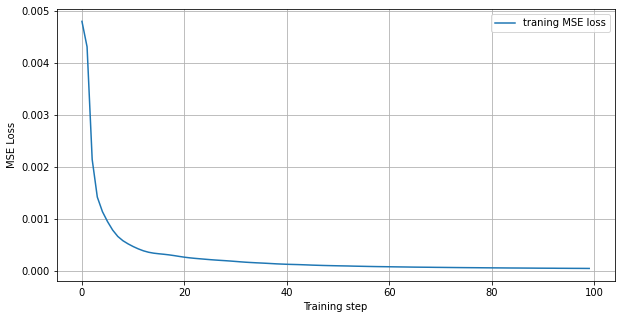

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(loss_list,label='traning MSE loss')
plt.ylabel('MSE Loss')
plt.xlabel('Training step')
plt.grid()
plt.legend(loc='best')
plt.show()

c:\Users\rsafa\Desktop\Ramin\venv\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
c:\Users\rsafa\Desktop\Ramin\venv\lib\site-packages\torch\nn\functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


frame  1 :


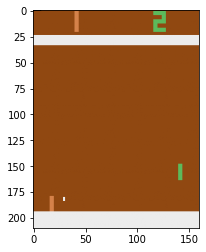

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


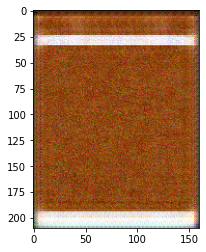

frame  2 :


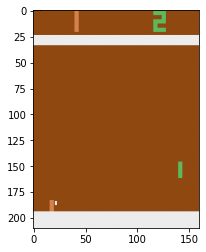

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


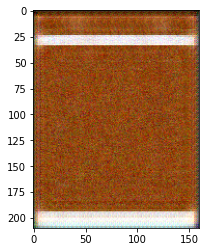

frame  3 :


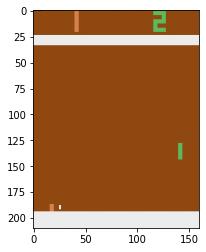

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


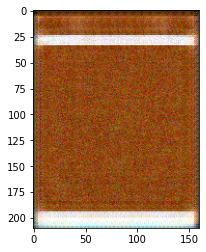

frame  4 :


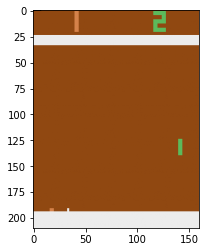

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


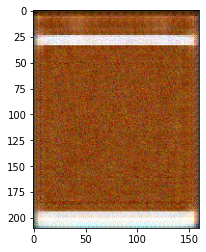

frame  5 :


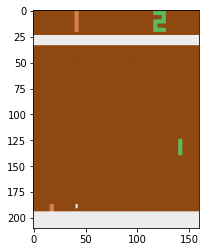

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


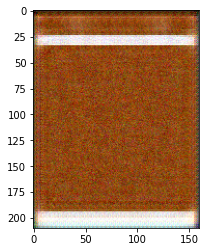

frame  6 :


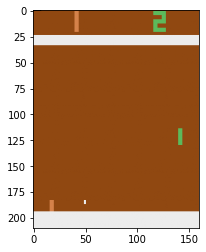

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


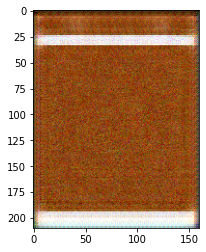

frame  7 :


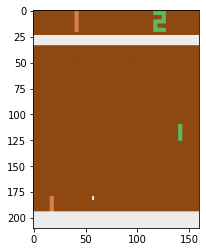

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


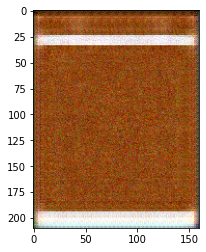

frame  8 :


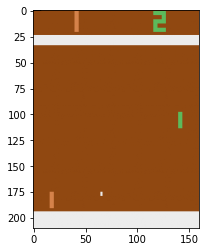

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


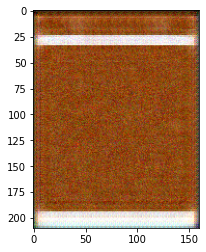

frame  9 :


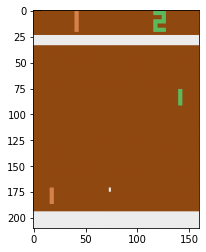

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


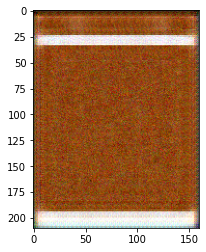

frame  10 :


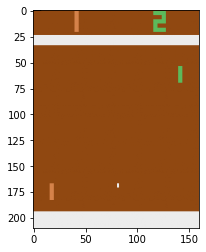

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


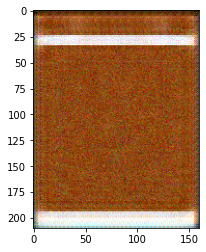

frame  11 :


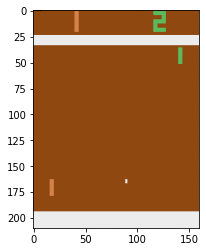

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


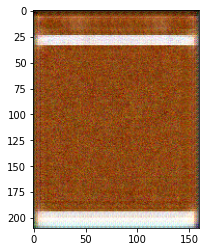

frame  12 :


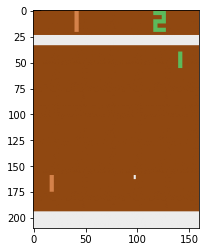

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


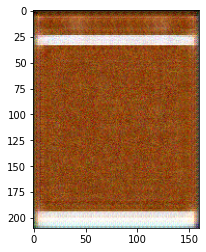

frame  13 :


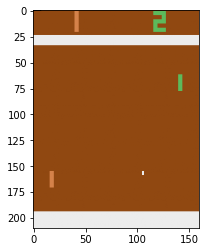

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


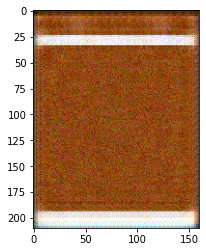

frame  14 :


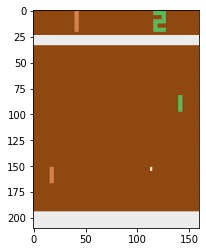

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


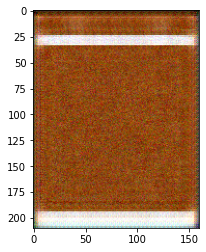

frame  15 :


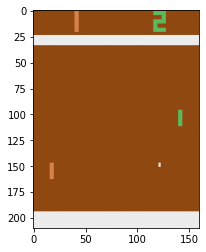

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


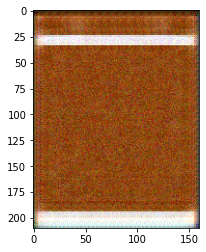

In [8]:
import matplotlib.pyplot as plt

with torch.no_grad():
    temp_states, temp_actions = test_data_loader.get_data(1,15)
    # temp_states, temp_actions = train_data_loader.get_data(1,15)
    states_tensor = torch.Tensor(temp_states) # of shape (1,16,dim1,dim2)
    actions_tensor = nn.functional.one_hot(torch.Tensor(temp_actions.astype(int)).long(),num_classes=3) # if I don't put the long() method, one_hot won't work
    # actions_tensor = torch.transpose(actions_tensor,-1,-2).float() # swap dimensions -1 and -2
    actions_tensor = actions_tensor[:,:,:,None].float()

    # actions_tensor is of shape (1,16,3)
    output_tensor = torch.zeros((1,SEQ_LENGTH,depth,dim1,dim2))
    h = torch.zeros([1,LSTM_config[1]])
    c = torch.zeros([1,LSTM_config[1]])
    for i in range(SEQ_LENGTH):
        out,(h,c) = model(states_tensor[:,i,:,:,:],
                          actions_tensor[:,i,:,:],
                          (h,c))
        output_tensor[:,i,:,:,:] = out
    output_images = output_tensor.numpy().transpose(0,1,3,4,2)

    for i in range(SEQ_LENGTH):
        print('frame ',i+1,':')
        plt.imshow(temp_states[0,i+1,:,:,:].transpose(1,2,0))
        plt.show()
        plt.imshow(output_images[0,i,:,:,:])
        plt.show()
    
    

In [10]:
temp_states.shape
temp_states[0,0,0:5,0:5,0:5]
np.max(temp_states)

0.9254901960784314